# Прогнозирование уровня средней заработной платы в России

Есть данные о заработной плате за каждый месяц с января 1993 по август 2016, необходимо построить прогноз на каждый месяц на два года вперёд.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

# обратное преобразование бокса-кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Посмотрим, что есть в нашем DataFrame и построим график.

            WAG_C_M
month              
1993-01-01     15.3
1993-02-01     19.1
1993-03-01     23.6
1993-04-01     30.6
1993-05-01     37.5
first data 1993-01-01 00:00:00
last data  2016-08-01 00:00:00


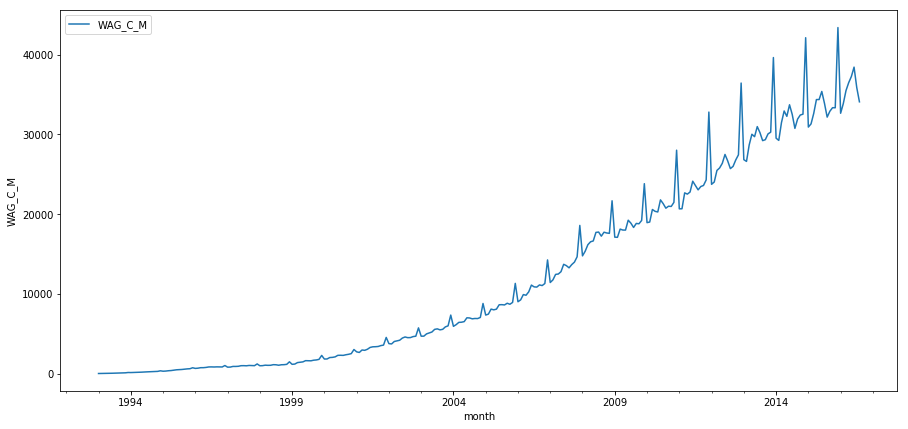

In [2]:
WAG= pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
WAG.head()
print(WAG.head())
print('first data',WAG.index.min())
print('last data ',WAG.index.max())
plt.figure(figsize(15,7))
WAG.plot()
plt.ylabel('WAG_C_M')
plt.show()

Подробно разберем свойства ряда

Критерий Дики-Фуллера: p=0.991850


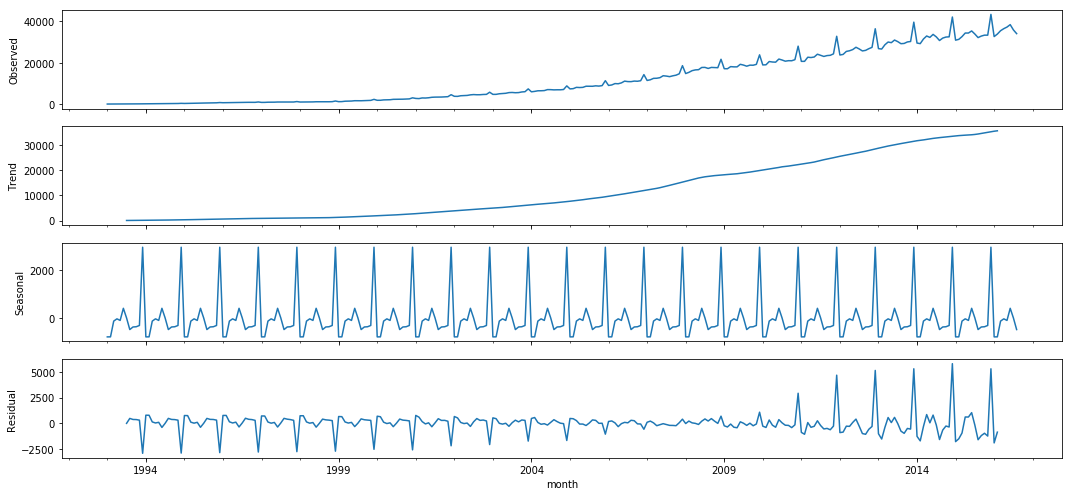

In [3]:
WAG_C_M= WAG['WAG_C_M'].values
# Проверка стационарности и STL-декомпозиция ряда:
sm.tsa.seasonal_decompose(WAG).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG_C_M)[1])

При визуальном анализе видно, что наш ряд не стационарный с ярко выраженной тенденцией, дисперсия растет от начала до конца ряда, присутсвует сезонность. Критерий Дики-Фуллера p=0.99 не отвергает гипотезу о нестационарности ряда. 

Для начала стабилизируем дисперсию преобразованием Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


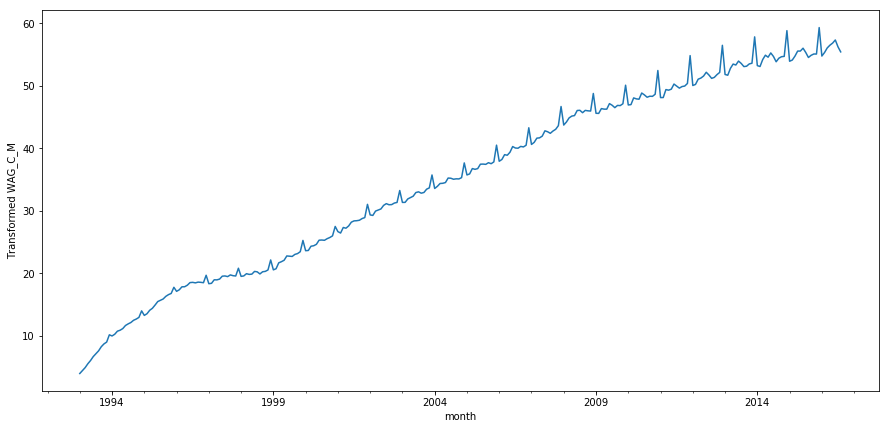

In [4]:
WAG['WAG_C_M_boxcox'], lmbda = stats.boxcox(WAG_C_M)
WAG.WAG_C_M_boxcox.plot()
plt.ylabel(u'Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_boxcox)[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и визуально в данных виден тренд.

Применим сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


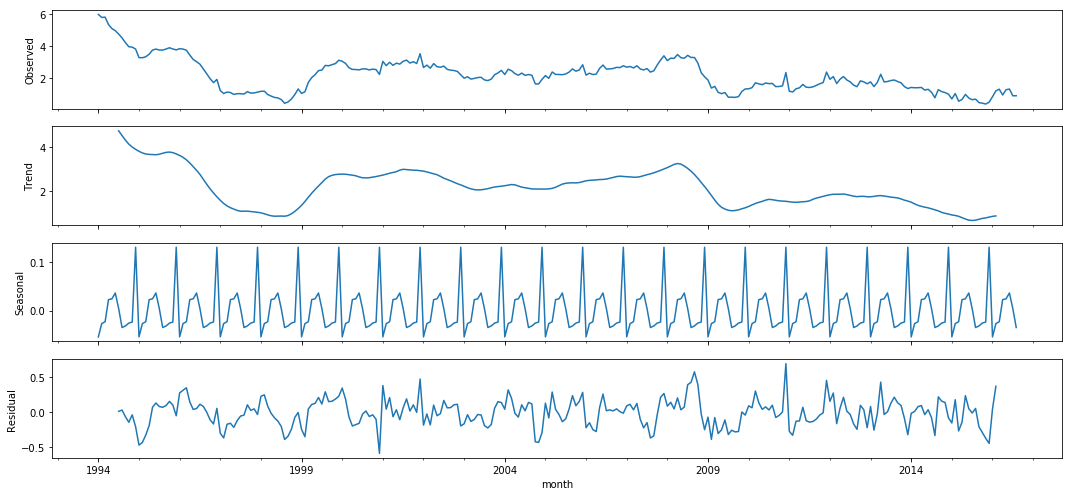

In [5]:
WAG['WAG_C_M_boxcox_diff'] = WAG.WAG_C_M_boxcox - WAG.WAG_C_M_boxcox.shift(12)
sm.tsa.seasonal_decompose(WAG.WAG_C_M_boxcox_diff[12:]).plot()
print ("Критерий Дики-Фуллера: p=%f" %sm.tsa.stattools.adfuller(WAG.WAG_C_M_boxcox_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Добавим ещё обычное дифференцирование (вычитание значения предыдущего элемента ряда из текущего):

Критерий Дики-Фуллера: p=0.000000


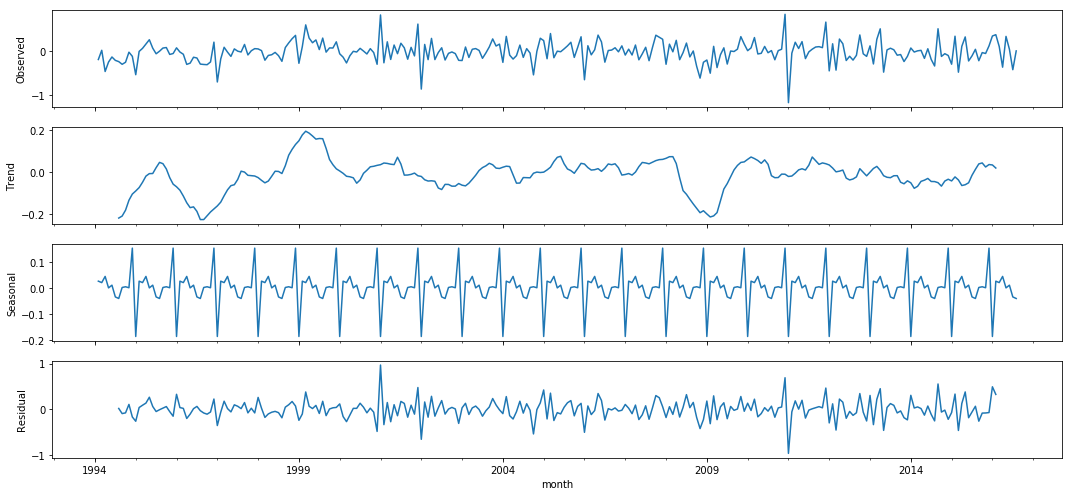

In [6]:
WAG['WAG_C_M_boxcox_diff2'] = WAG.WAG_C_M_boxcox_diff - WAG.WAG_C_M_boxcox_diff.shift(1)
sm.tsa.seasonal_decompose(WAG.WAG_C_M_boxcox_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" %sm.tsa.stattools.adfuller(WAG.WAG_C_M_boxcox_diff2[13:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, визуально ряд стационарен. Переходим к построению регрессионной модели

## Подбор модели


Посмотрим на ACF и PACF полученного ряда:

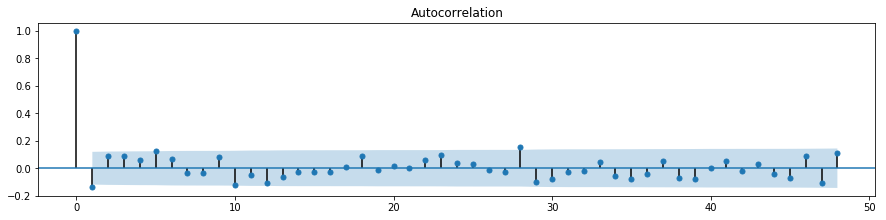

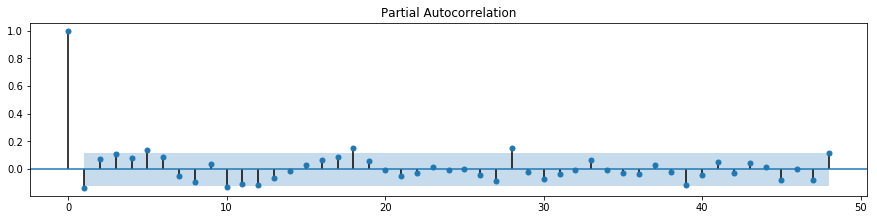

In [7]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.WAG_C_M_boxcox_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.WAG_C_M_boxcox_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Будем использовать модель ARIMA с приставкой S - сезонное дифференцирование https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

Начальные приближения:
ACF график.  Последний сезонный значимый лаг Q= 1; последний значимый лаг q= 5;
PACF график. Последний сезонный значимый лаг P= 1; последний значимый лаг  p= 5.

In [8]:
ps = range(0, 4)
d = 1 # количество дифференцирований
qs = range(0, 4)
Ps = range(0, 2)
D = 1 # количество сезонных дифференцирований
Qs = range(0, 2)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [13]:
%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.WAG_C_M_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except (ValueError, np.linalg.LinAlgError):
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

Wall time: 0 ns
wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 0, 1)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (2, 3, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 0, 1)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 3, 1, 1)


In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
25  (1, 3, 1, 0) -10.544650
26  (1, 3, 1, 1)  -9.882173
24  (1, 3, 0, 1)  -9.678356
23  (1, 3, 0, 0)  -5.362795
37  (3, 1, 1, 0)  -4.995859


Лучшая модель:

In [15]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     WAG_C_M_boxcox   No. Observations:                  284
Model:             SARIMAX(1, 1, 3)x(1, 1, 0, 12)   Log Likelihood                  11.272
Date:                            Mon, 13 Aug 2018   AIC                            -10.545
Time:                                    18:29:08   BIC                             11.349
Sample:                                01-01-1993   HQIC                            -1.767
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7721      0.127      6.092      0.000       0.524       1.020
ma.L1         -0.9928      0.131   

Выведем остатки:

Критерий Стьюдента: p=0.277455
Критерий Дики-Фуллера: p=0.000000


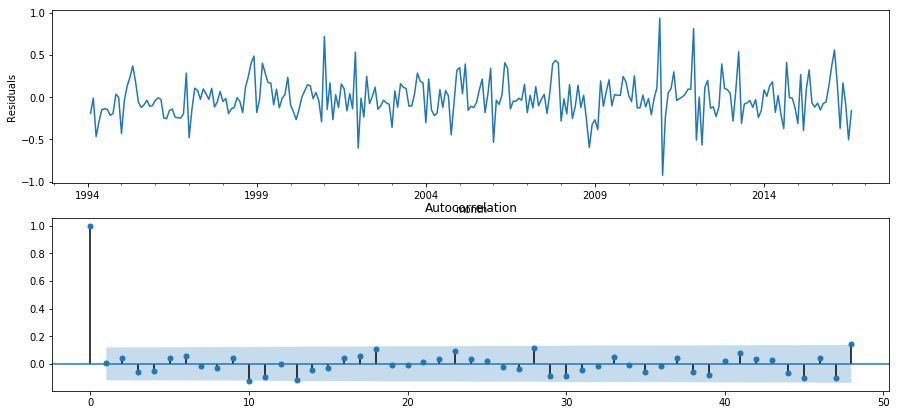

In [16]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально). Посмотрим, насколько хорошо модель описывает данные:

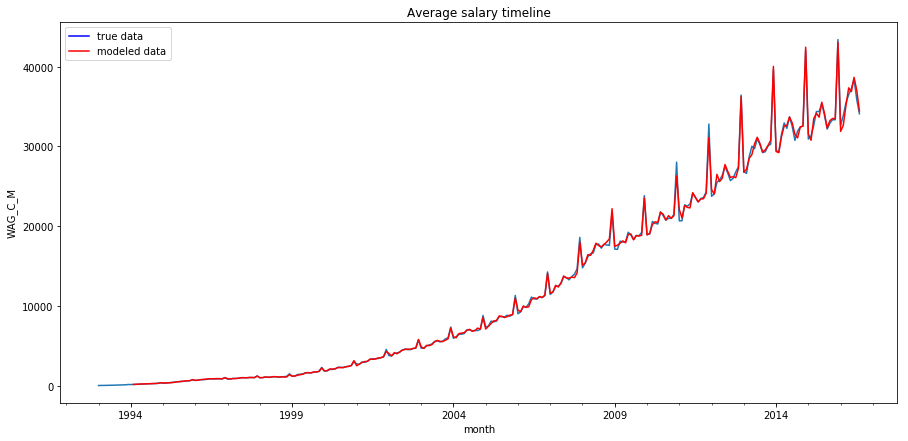

In [24]:
# Производим обратное преобразование бокса-кокса
WAG['model'] = invboxcox(best_model.fittedvalues, lmbda)
WAG.WAG_C_M.plot()
WAG.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
plt.title('Average salary timeline')
import matplotlib.lines as mlines
true_marker = mlines.Line2D([], [], color='blue', linestyle='solid', label='true data')
pred_marker = mlines.Line2D([], [], color='red', linestyle='solid', label='modeled data')
plt.legend(handles=[true_marker,pred_marker])
plt.show()

Визуально видно, что модель дает корректные предсказания, строим прогноз на будущее

### Прогноз

Сгененрируем даты на 2 года вперед и получим предсказания на значения средней зарплаты

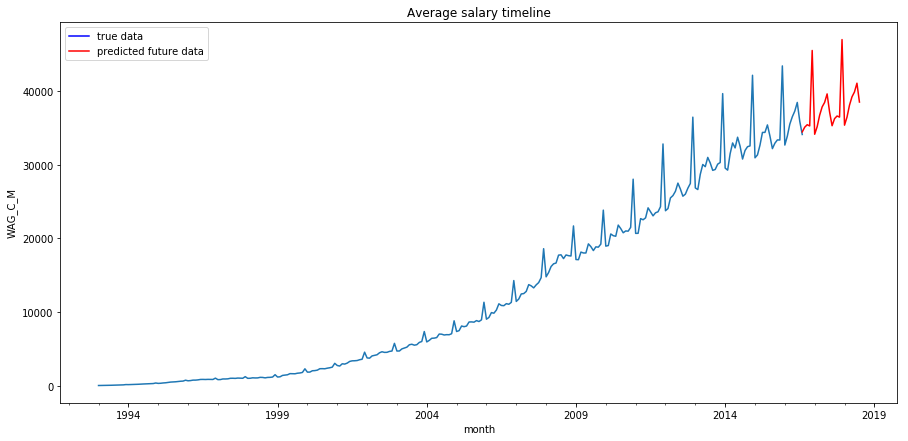

In [26]:
WAG2 = WAG[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= WAG2.columns)
WAG2 = pd.concat([WAG2, future])
WAG2['forecast'] = invboxcox(best_model.predict(start=283, end=307), lmbda)


WAG.WAG_C_M.plot()
WAG2.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
true_marker = mlines.Line2D([], [], color='blue', linestyle='solid', label='true data')
pred_marker = mlines.Line2D([], [], color='red', linestyle='solid', label='predicted future data')
plt.legend(handles=[true_marker,pred_marker])
plt.title('Average salary timeline')
plt.show()

Спасибо за внимание!